In [ ]:
!pip install pyspellchecker
!pip install emoji
!pip install pyLDAvis
!pip install keras

     |████████████████████████████████| 1.9MB 12.5MB/s 
     |████████████████████████████████| 51kB 3.4MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49715 sha256=456eeffba0d4ef709380fe581fd85ec323d1a0c2e131b5b156f0db0cd0b97a59
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
     |████████████████████████████████| 1.6MB 11.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=c91b03f0533147cc6f03e838b805bffc288ca02ad4c9e1e1ee222eca2fc49e26
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import nltk
import string
import emoji
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from tqdm import tqdm
from gensim.parsing.preprocessing import remove_stopwords
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA #standardize
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The dataset can be found here:
https://www.kaggle.com/zynicide/wine-reviews

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CIS545_2020/winemag-data-130k-v2.csv',index_col=0)
df.drop_duplicates(inplace = True)

In [ ]:
# check missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119988 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                119929 non-null  object 
 1   description            119988 non-null  object 
 2   designation            85443 non-null   object 
 3   points                 119988 non-null  int64  
 4   price                  111593 non-null  float64
 5   province               119929 non-null  object 
 6   region_1               100428 non-null  object 
 7   region_2               46769 non-null   object 
 8   taster_name            95071 non-null   object 
 9   taster_twitter_handle  90542 non-null   object 
 10  title                  119988 non-null  object 
 11  variety                119987 non-null  object 
 12  winery                 119988 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.8+ MB


# **Data Cleaning**

In [ ]:
# merge the region name
df['region'] = df[['region_1','region_2']].apply(lambda x:x[0] if x[0] is not np.nan else x[1],axis = 1)
df.drop(columns = {'region_1','region_2'},inplace = True)
df['region'] = df['region'].fillna('Unknown')

In [ ]:
# merge the taster name
df['taster'] = df[['taster_name','taster_twitter_handle']].apply(lambda x:x[0] if x[0] is not np.nan else x[1],axis = 1)
df.drop(columns = {'taster_name','taster_twitter_handle'},inplace = True)
df['taster'] = df['taster'].fillna('Unknown')
df.dropna(subset=['country'],inplace = True)

In [ ]:
# We are going to recommend wines with points greater than 88 to our customers.
df['target'] = df['points'].apply(lambda x:1 if x >= 88 else 0)

In [ ]:
# remove url
def remove_url(text):
    text = re.compile(r'https?://\S+|www\.\S+').sub(r'',text)
    return text

#remove html tags
def remove_html(text):
    text = re.compile(r'<.*?>').sub(r'',text)
    return text

def remove_emoji(text):
    text = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE).sub(r'',text)
    text = emoji.demojize(text)
    text = re.sub(':\S+?:', ' ', text)
    return text

def remove_punctuation(text):
    text = text.translate(str.maketrans('','', string.punctuation))
    return text

def remove_stopword(text):
    text = remove_stopwords(text)
    return text

In [ ]:
df['description'] = df['description'].apply(lambda x:remove_url(x))
df['description'] = df['description'].apply(lambda x:remove_html(x))
df['description'] = df['description'].apply(lambda x:remove_emoji(x))
df['description'] = df['description'].apply(lambda x:remove_punctuation(x))
df['description'] = df['description'].apply(lambda x: x.lower())
df['description'] = df['description'].apply(lambda x:remove_stopwords(x))

# **Data Visualization**

In [ ]:
# Helper function
def plot_20_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='20 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


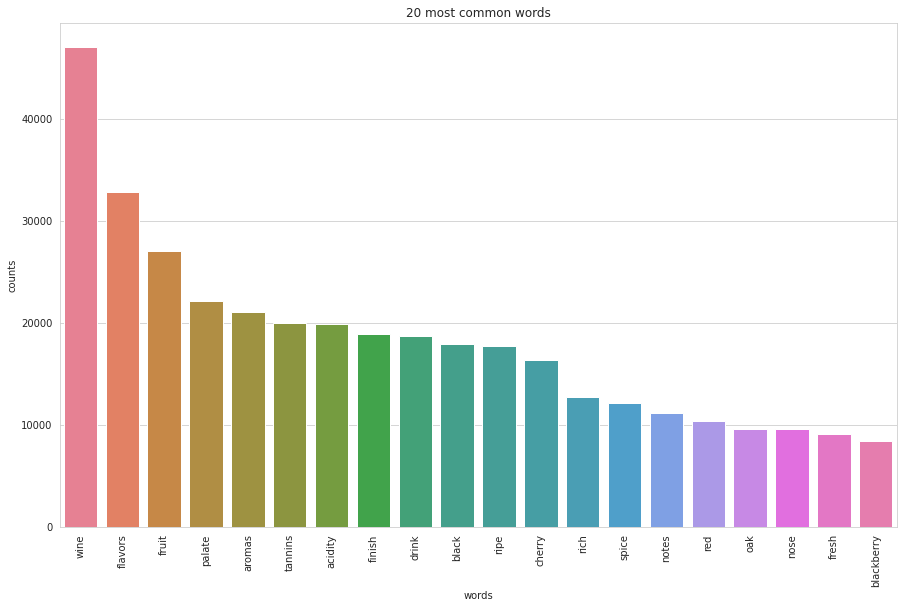

In [ ]:
# select text with target = 1
df_recommend = df[df.target == 1]

count_vectorizer_text = CountVectorizer()
text_data = count_vectorizer_text.fit_transform(df_recommend['description'])
plot_20_most_common_words(text_data, count_vectorizer_text)

In [ ]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
number_topics = 10
number_words = 10

# Create and fit the LDA model
text_lda = LDA(n_components=number_topics)
text_lda.fit(text_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(text_lda, count_vectorizer_text, number_words)

Topics found via LDA:

Topic #0:
aromas palate white fruit acidity mineral offers almond apple bright

Topic #1:
wine flavors cherry fruit spice rich tannins black chocolate blackberry

Topic #2:
flavors finish aromas drink plum palate berry blackberry notes oak

Topic #3:
wine flavors acidity crisp fruit oak light citrus pinot white

Topic #4:
wine drink acidity ripe fruits fruit tannins rich flavors character

Topic #5:
cabernet blend wine sauvignon flavors black merlot fruit oak tannins

Topic #6:
flavors finish palate apple acidity peach aromas lemon nose lime

Topic #7:
palate cherry black tannins aromas red pepper nose spice offers

Topic #8:
palate fruit notes nose freshness finish fresh wine ripe lemon

Topic #9:
fruit wine finish flavors cherry hints drink tart mix raspberry


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(text_lda, text_data, count_vectorizer_text)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
with open(LDAvis_data_filepath,'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.100234  0.091973       1        1  15.823280
7      0.004277 -0.245724       2        1  13.594268
2     -0.088177 -0.083274       3        1  11.404386
5     -0.176024 -0.002440       4        1  10.858462
1     -0.135364 -0.024213       5        1  10.491833
6      0.170420  0.064914       6        1   9.764022
3      0.058803  0.179015       7        1   9.640893
9     -0.109570  0.049162       8        1   7.190173
8      0.121065  0.070949       9        1   6.338329
0      0.254805 -0.100360      10        1   4.894354, topic_info=           Term          Freq         Total Category  logprob  loglift
22312    palate  21803.000000  21803.000000  Default  30.0000  30.0000
5232   cabernet   6678.000000   6678.000000  Default  29.0000  29.0000
2433     aromas  20693.000000  20693.000000  Default  28.0000  28.0000
6404     cherry  16243.000000  16243.000000  Default  27.0000  27.0000
34278      wine  45931.000000  45931.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
10570   elegant    638.970927   3961.306704  Topic10  -4.9686   1.1926
8472      crisp    700.495564   6077.333118  Topic10  -4.8767   0.8566
12009    finish    800.520104  18576.082678  Topic10  -4.7432  -0.1273
14125     green    595.170499   3808.509694  Topic10  -5.0396   1.1609
21166      nose    635.034312   9464.854687  Topic10  -4.9748   0.3154

[879 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
14         1  0.070528    10
14         2  0.113929    10
14         4  0.654124    10
14         5  0.070528    10
14         6  0.045727    10
...      ...       ...   ...
34774      4  0.174819   zin
34774      5  0.816777   zin
34774      8  0.005732   zin
34804      4  0.044800  zins
34804      5  0.940794  zins

[2604 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 3, 6, 2, 7, 4, 10, 9, 1])

In [ ]:
df.describe()

,points,price,target
count,119929.000000,111538.000000,119929.000000
mean,88.442145,35.626109,0.727572
std,3.093275,42.112910,0.445211
min,80.000000,4.000000,0.000000
25%,86.000000,17.000000,0.000000
50%,88.000000,25.000000,1.000000
75%,91.000000,42.000000,1.000000
max,100.000000,3300.000000,1.000000


In [ ]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
# data = df['country'].replace("US", "United States").value_counts()
# iplot([go.Choropleth(locationmode='country names',locations=data.index.values,text=data.index,z=data.values,
#     colorscale='portland')])

fig = go.Figure(
    go.Choroplethmapbox(
        # geojson=provinces_map,
        # featureidkey=" ",
        locations=data['country'],
        z=data.values,
        zauto=True,
        colorscale='viridis',
        marker_opacity=0.8,
        marker_line_width=0.8,
        showscale=True,
    )
)

fig.update_layout(
    mapbox_style="carto-darkmatter",
    mapbox_zoom=3,
    # mapbox_center={"lat": 37.110573, "lon": 106.493924},
)

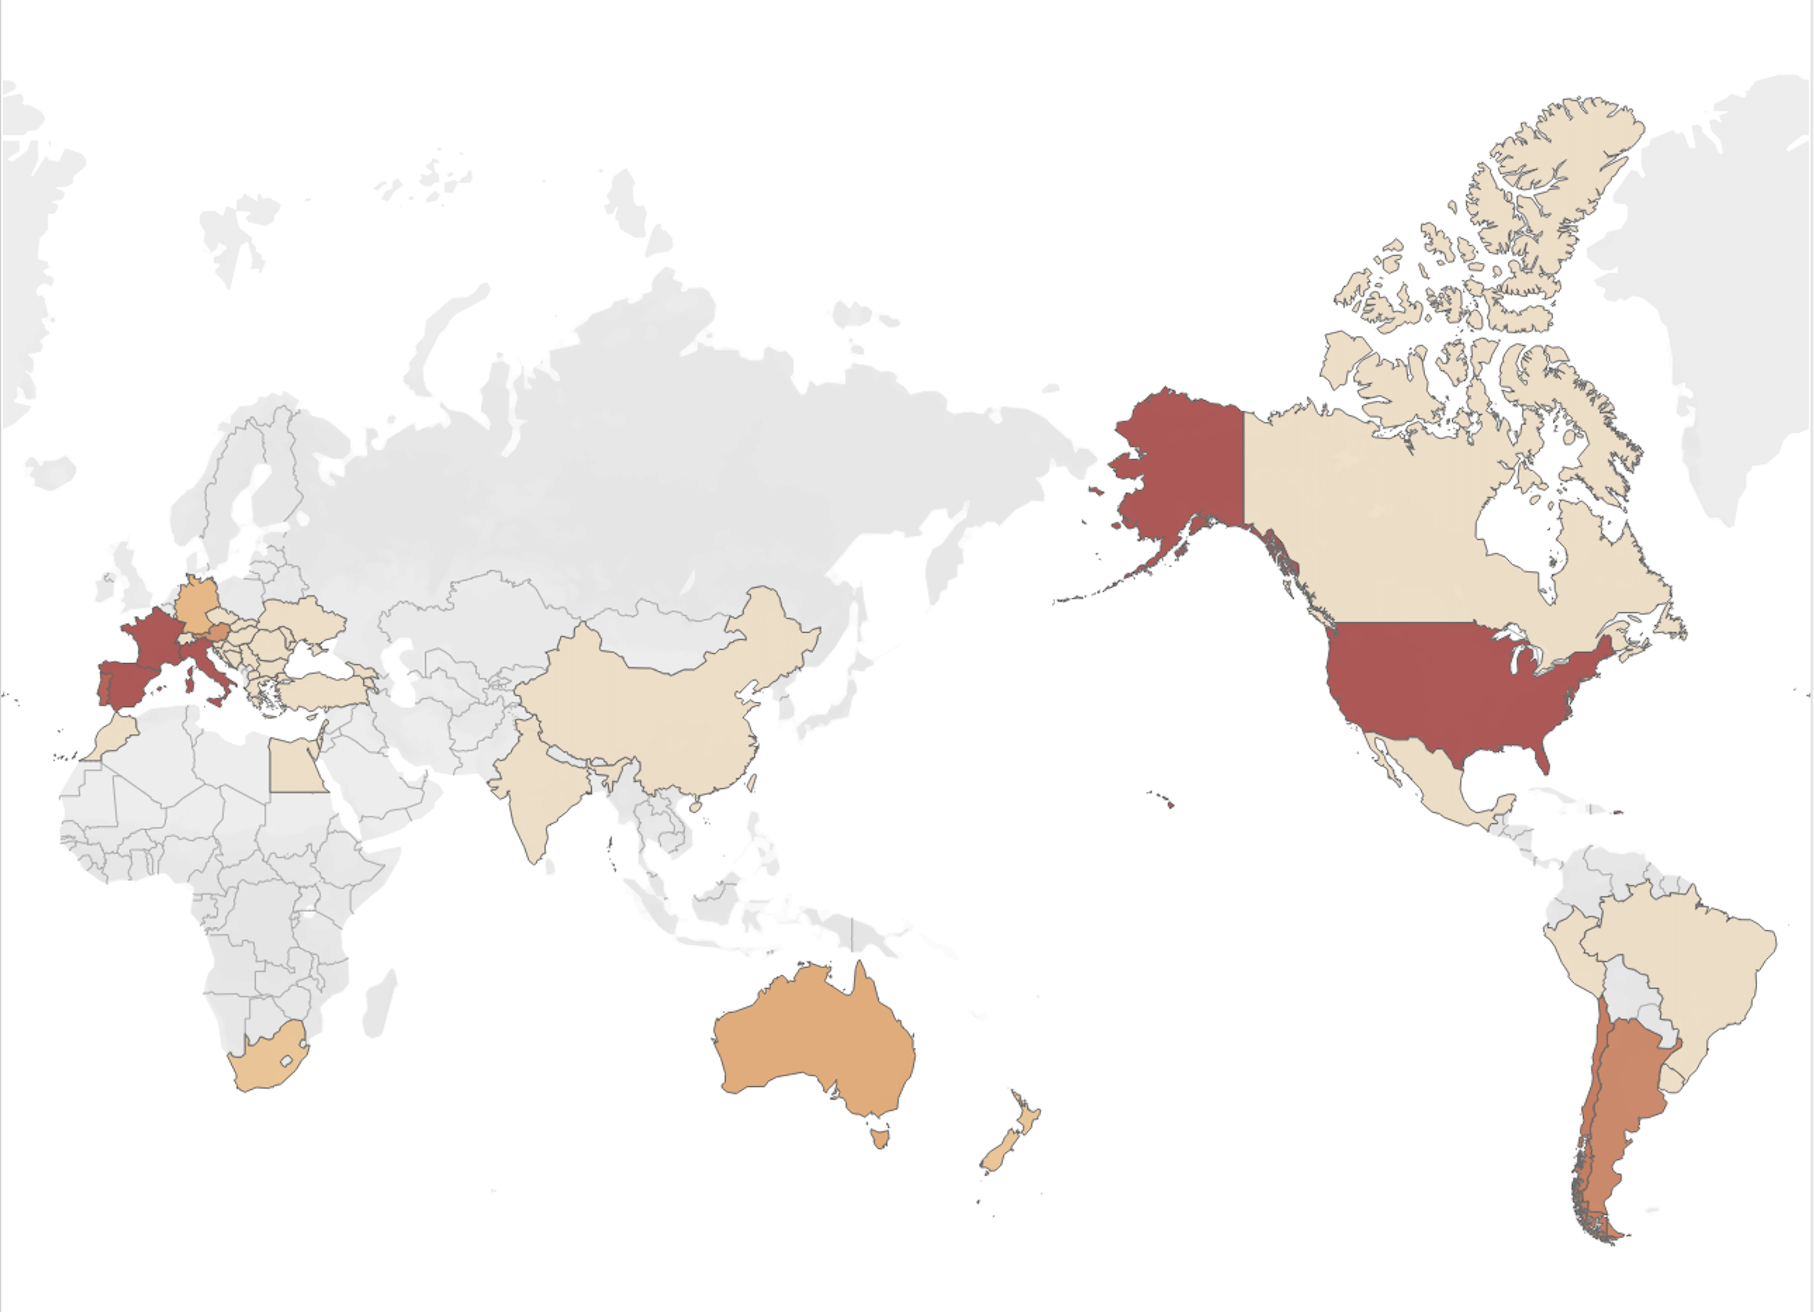

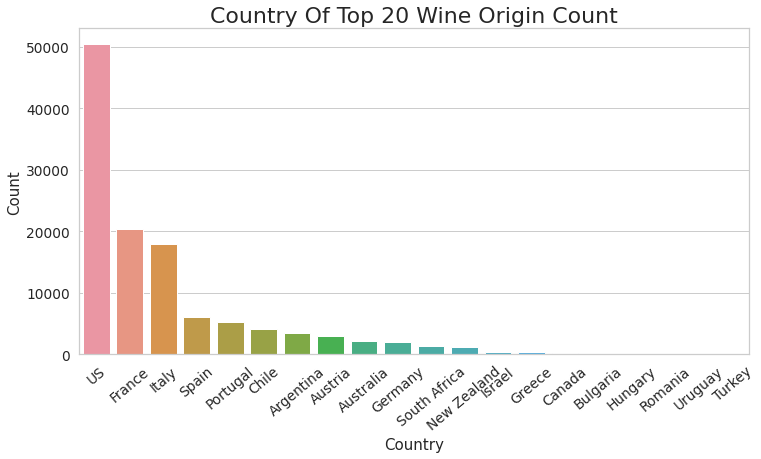

In [ ]:
plt.figure(figsize=(12,6))

country = df.country.value_counts()[:20].sort_values()

country_count_plot = sns.countplot(x='country',data=df, order=df['country'].value_counts()[:20].index)
country_count_plot.set_title("Country Of Top 20 Wine Origin Count", fontsize=22)
country_count_plot.set_xlabel("Country", fontsize=15)
country_count_plot.set_ylabel("Count", fontsize=15)
country_count_plot.set_xticklabels(country_count_plot.get_xticklabels(),rotation=40)

plt.show()

In [ ]:
countries = df.country.value_counts()
temp_dict = countries[countries>500].to_dict()
temp_dict['Other'] = countries[countries<501].sum()
less_countries = pd.Series(temp_dict)
less_countries.sort_values(ascending=False, inplace=True)
df_less_con = less_countries.to_frame()
df_less_con.columns=['Number of Reviews']
df_less_con.index.name = 'Country'
df_less_con.style.background_gradient(cmap='coolwarm')

,Number of Reviews
Country,
US,50457
France,20353
Italy,17940
Spain,6116
Portugal,5256
Chile,4184
Argentina,3544
Austria,3034
Other,2277


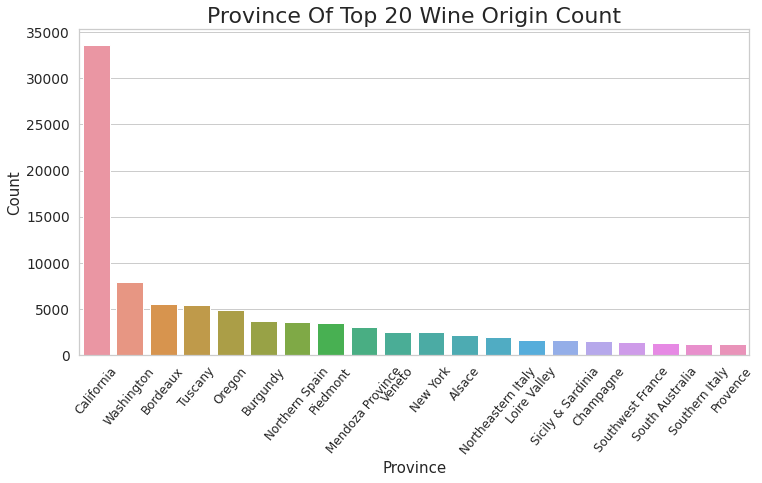

In [ ]:
plt.figure(figsize=(12,6))

province = df.province.value_counts()[:20]

province_count_plot = sns.countplot(x='province',data=df, order= df['province'].value_counts()[:20].index)
province_count_plot.set_title("Province Of Top 20 Wine Origin Count", fontsize=22)
province_count_plot.set_xlabel("Province", fontsize=15)
province_count_plot.set_ylabel("Count", fontsize=15)
province_count_plot.set_xticklabels(province_count_plot.get_xticklabels(),fontsize=12,rotation=50)

plt.show()

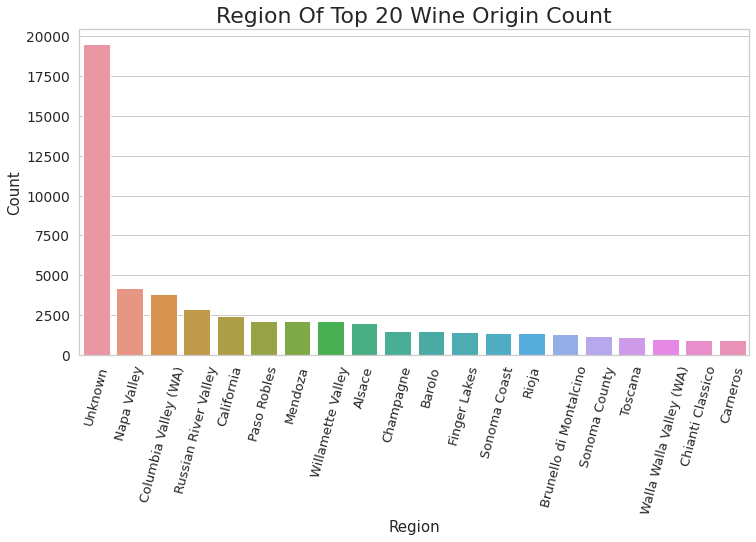

In [ ]:
plt.figure(figsize=(12,6))

region = df.region.value_counts()[:20]

region_count_plot = sns.countplot(x='region',data=df, order=df['region'].value_counts()[:20].index)
region_count_plot.set_title("Region Of Top 20 Wine Origin Count", fontsize=22)
region_count_plot.set_xlabel("Region", fontsize=15)
region_count_plot.set_ylabel("Count", fontsize=15)
region_count_plot.set_xticklabels(region_count_plot.get_xticklabels(),fontsize=13,rotation=75)

plt.show()

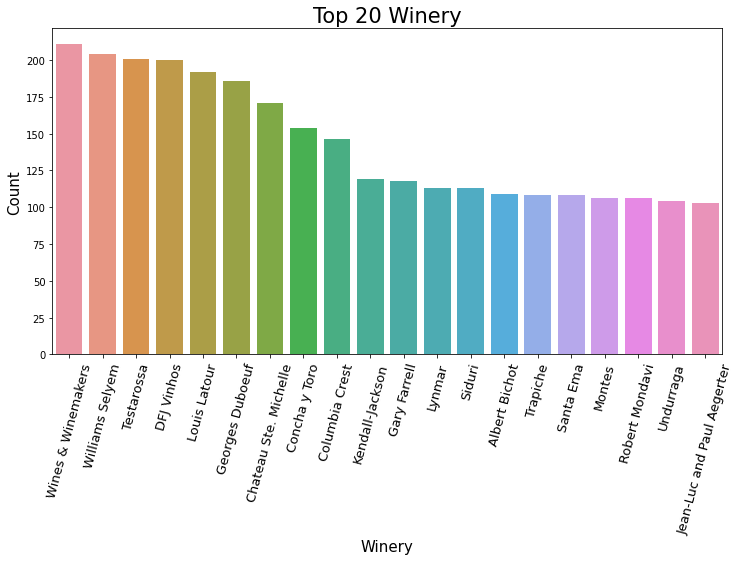

In [ ]:
plt.figure(figsize=(12,6))

winery = df.winery.value_counts()[:20]
winery_count_plot = sns.countplot(x='winery',data=df, order=df['winery'].value_counts()[:20].index)
winery_count_plot.set_title("Top 20 Winery", fontsize=21)
winery_count_plot.set_xlabel("Winery", fontsize=15)
winery_count_plot.set_ylabel("Count", fontsize=15)
winery_count_plot.set_xticklabels(winery_count_plot.get_xticklabels(),fontsize=13,rotation=75)

plt.show()

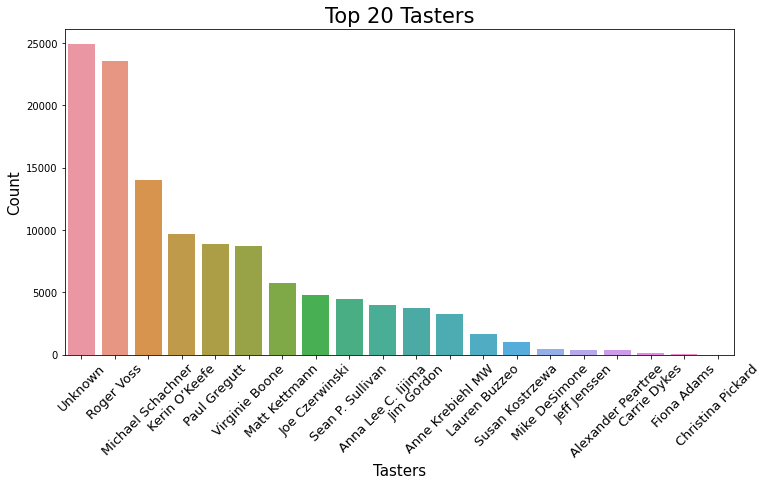

In [ ]:
plt.figure(figsize=(12,6))

taster = df.taster.value_counts()[:20]
taster_count_plot = sns.countplot(x='taster',data=df, order=df['taster'].value_counts()[:20].index)
taster_count_plot.set_title("Top 20 Tasters", fontsize=21)
taster_count_plot.set_xlabel("Tasters", fontsize=15)
taster_count_plot.set_ylabel("Count", fontsize=15)
taster_count_plot.set_xticklabels(taster_count_plot.get_xticklabels(),fontsize=13,rotation=45)

plt.show()

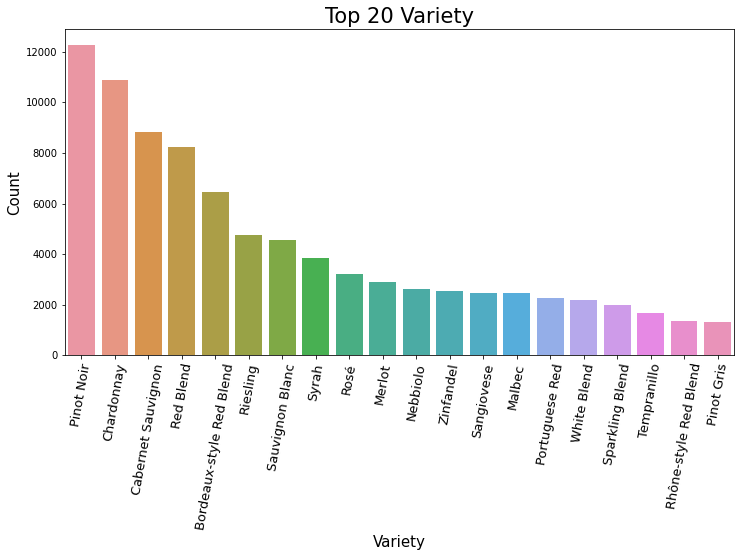

In [ ]:
plt.figure(figsize=(12,6))

variety = df.variety.value_counts()[:20]
variety_count_plot = sns.countplot(x='variety',data=df, order=df['variety'].value_counts()[:20].index)
variety_count_plot.set_title("Top 20 Variety", fontsize=21)
variety_count_plot.set_xlabel("Variety", fontsize=15)
variety_count_plot.set_ylabel("Count", fontsize=15)
variety_count_plot.set_xticklabels(variety_count_plot.get_xticklabels(),fontsize=13,rotation=80)

plt.show()

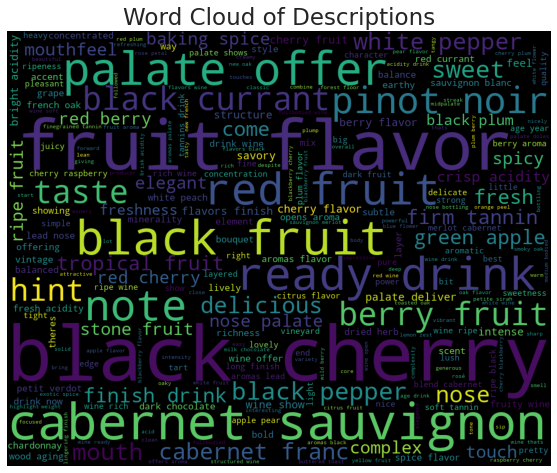

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(
    # background_color='white',
    # stopwords=stopwords,
    max_words=250,
    max_font_size=200, 
    width=1000, height=800,
    random_state=40,
).generate(" ".join(df['description'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (14,8))
plt.imshow(wordcloud)
plt.title("Word Cloud of Descriptions",fontsize=23)
plt.axis('off')
plt.show()

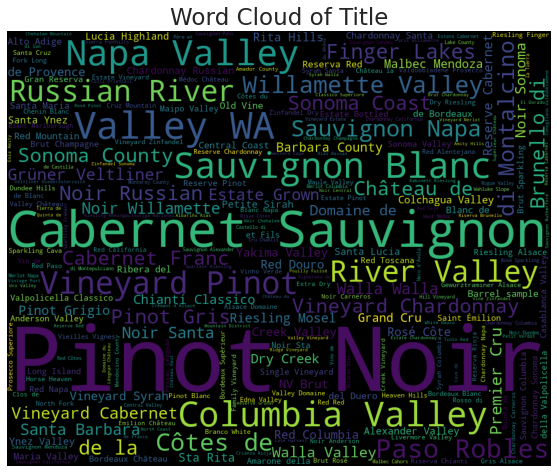

In [ ]:
wordcloud = WordCloud(
    max_words=250,
    max_font_size=200, 
    width=1000, height=800,
    random_state=40,
).generate(" ".join(df['title'].astype(str)))

print(wordcloud)
fig = plt.figure(figsize = (14,8))
plt.imshow(wordcloud)
plt.title("Word Cloud of Title",fontsize=23)
plt.axis('off')
plt.show()

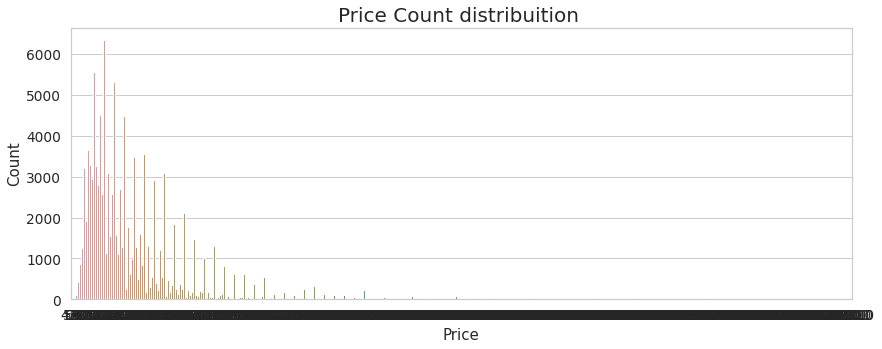

In [ ]:
plt.figure(figsize=(14,5))

g = sns.countplot(x='price', data=df) 
g.set_title("Price Count distribuition ", fontsize=20) 
g.set_xlabel("Price", fontsize=15) 
g.set_ylabel("Count", fontsize=15) 

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


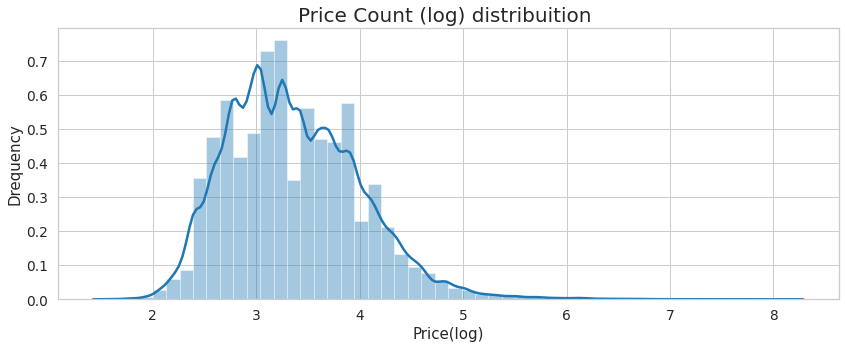

In [ ]:
plt.figure(figsize=(14,5))

price_distribution = sns.distplot(np.log(df['price'].dropna() + 1))
price_distribution.set_title("Price Count (log) distribuition ", fontsize=20) 
price_distribution.set_xlabel("Price(log)", fontsize=15) 
price_distribution.set_ylabel("Drequency", fontsize=15) 

plt.show()

In [ ]:
df['price_log'] = np.log(df['price'])

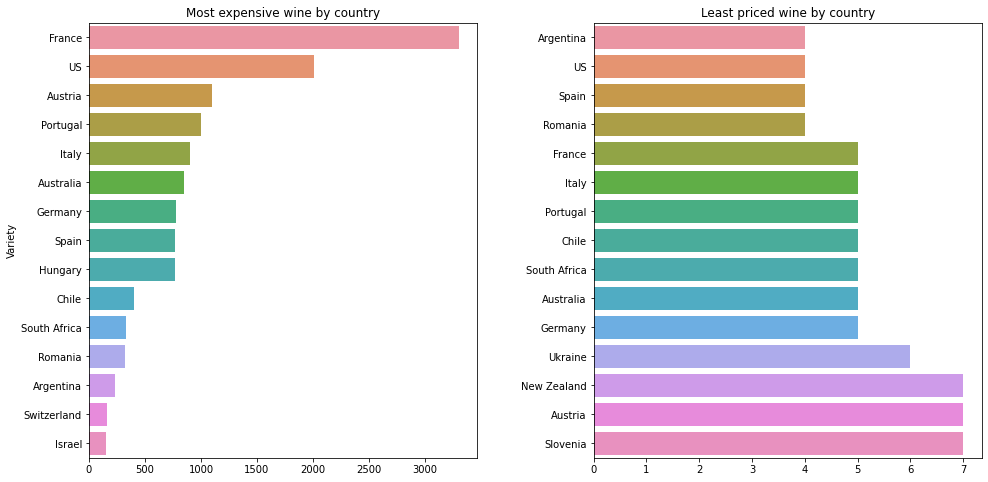

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['price'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index,ax=ax1) # , color='purple'
ax1.set_title('Most expensive wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['price'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['price'], y = w.index,ax=ax2) #  color='purple',
ax2.set_title('Least priced wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3)

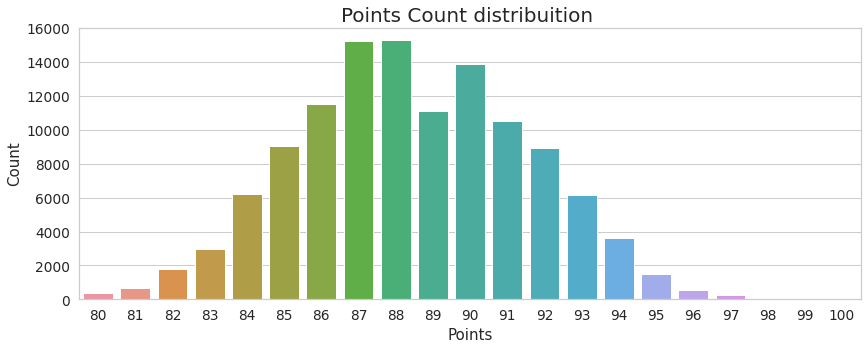

In [ ]:
plt.figure(figsize=(14,5))

point_distribution = sns.countplot(x='points', data=df) 
point_distribution.set_title("Points Count distribuition ", fontsize=20) 
point_distribution.set_xlabel("Points", fontsize=15) 
point_distribution.set_ylabel("Count", fontsize=15) 

plt.show()

In [ ]:
w = df.groupby(['country','points'])['price'].agg(['count','min','max','mean']).sort_values(by='mean',ascending=False)[:10]
w.reset_index(inplace=True)
w.style.background_gradient(high=1) # cmap='Wistia',

,country,points,count,min,max,mean
0,Germany,98,1,775.000000,775.000000,775.000000
1,France,100,8,150.000000,1500.000000,685.375000
2,Australia,99,2,300.000000,850.000000,575.000000
3,Portugal,100,2,450.000000,650.000000,550.000000
4,France,99,3,159.000000,800.000000,506.333333
5,Germany,97,7,245.000000,775.000000,464.714286
6,Spain,98,1,450.000000,450.000000,450.000000
7,France,98,14,70.000000,1900.000000,449.428571
8,Italy,100,4,210.000000,550.000000,372.500000
9,France,97,50,45.000000,2000.000000,363.380000


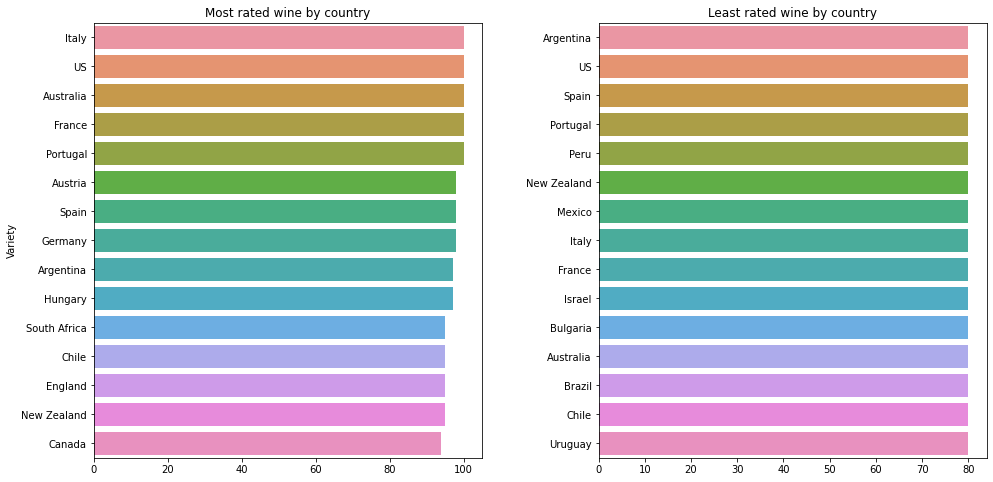

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,8))
ax1,ax2 = ax.flatten()
w = df.groupby(['country'])['points'].max().sort_values(ascending=False).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, ax=ax1)
ax1.set_title('Most rated wine by country')
ax1.set_ylabel('Variety')
ax1.set_xlabel('')
w = df.groupby(['country'])['points'].min().sort_values(ascending=True).to_frame()[:15]
sns.barplot(x = w['points'], y = w.index, ax=ax2)
ax2.set_title('Least rated wine by country')
ax2.set_ylabel('')
ax2.set_xlabel('')
plt.subplots_adjust(wspace=0.3)

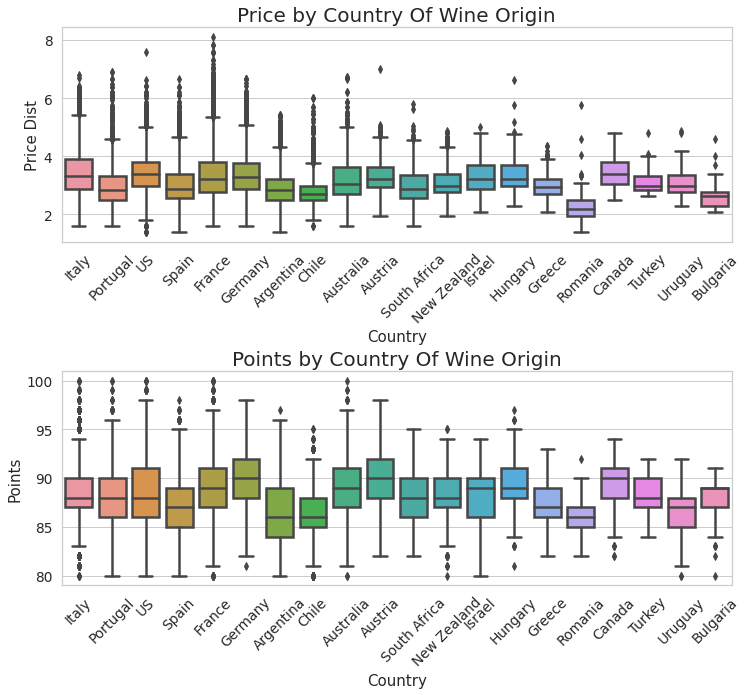

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
g1 = sns.boxplot(x='country', y='price_log',data=df.loc[(df.country.isin(country.index.values))],)
g1.set_title("Price by Country Of Wine Origin", fontsize=20)
g1.set_xlabel("Country", fontsize=15)
g1.set_ylabel("Price Dist", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)

plt.subplot(2,1,2)
g2 = sns.boxplot(x='country', y='points',
                   data=df[df.country.isin(country.index.values)],)
g2.set_title("Points by Country Of Wine Origin", fontsize=20)
g2.set_xlabel("Country", fontsize=15)
g2.set_ylabel("Points", fontsize=15)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.subplots_adjust(hspace = 0.6,top = 0.9)
plt.show()

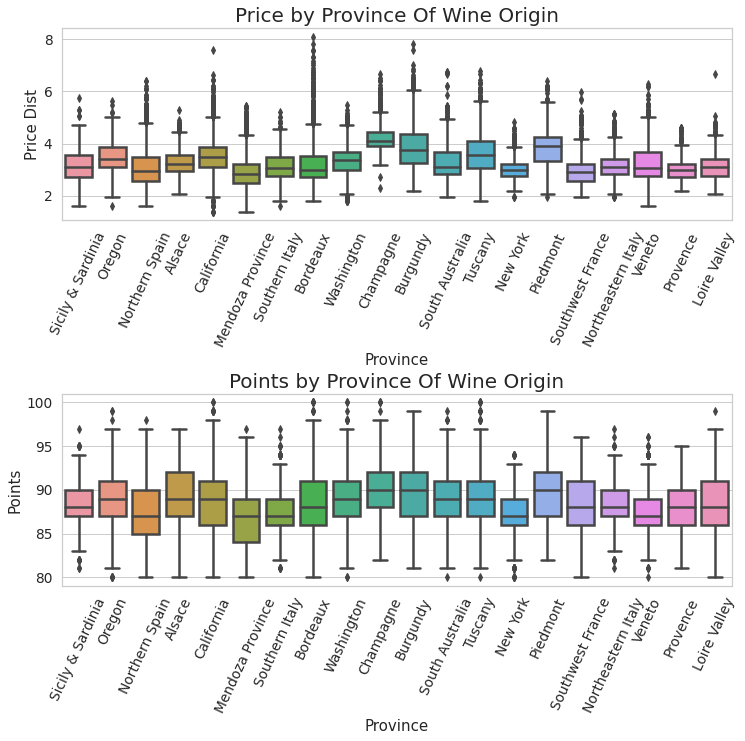

In [ ]:
plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
g1 = sns.boxplot(x='province', y='price_log',data=df.loc[(df.province.isin(province.index.values))],)
g1.set_title("Price by Province Of Wine Origin", fontsize=20)
g1.set_xlabel("Province", fontsize=15)
g1.set_ylabel("Price Dist", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=65)

plt.subplot(2,1,2)
g2 = sns.boxplot(x='province', y='points',
                   data=df[df.province.isin(province.index.values)],)
g2.set_title("Points by Province Of Wine Origin", fontsize=20)
g2.set_xlabel("Province", fontsize=15)
g2.set_ylabel("Points", fontsize=15)
g2.set_xticklabels(g2.get_xticklabels(),rotation=65)

plt.subplots_adjust(hspace = 1.2,top = 1.1)
plt.show()

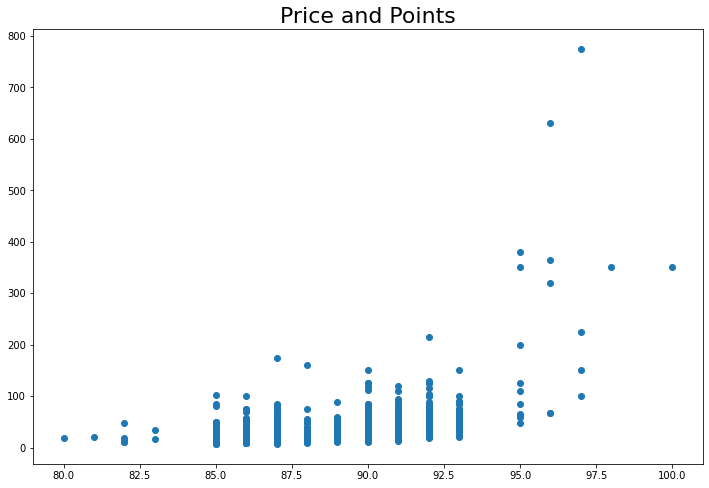

In [ ]:
plt.figure(figsize=(12,8))
# fig = plt.figure() 
# plt.add_subplot(111)
plt.scatter(x=df.head(1000)['points'],y=df.head(1000)['price'])
plt.title('Price and Points', fontsize = 22)
plt.show()

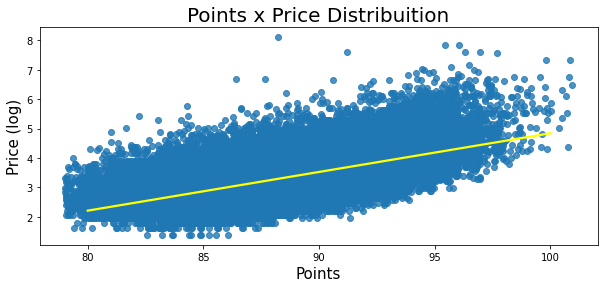

In [ ]:
plt.figure(figsize=(10,4))

g = sns.regplot(x='points', y='price_log', 
                data=df, line_kws={'color':'yellow'},
                x_jitter=True, fit_reg=True)
g.set_title("Points x Price Distribuition", fontsize=20)
g.set_xlabel("Points", fontsize= 15)
g.set_ylabel("Price (log)", fontsize= 15)

plt.show()

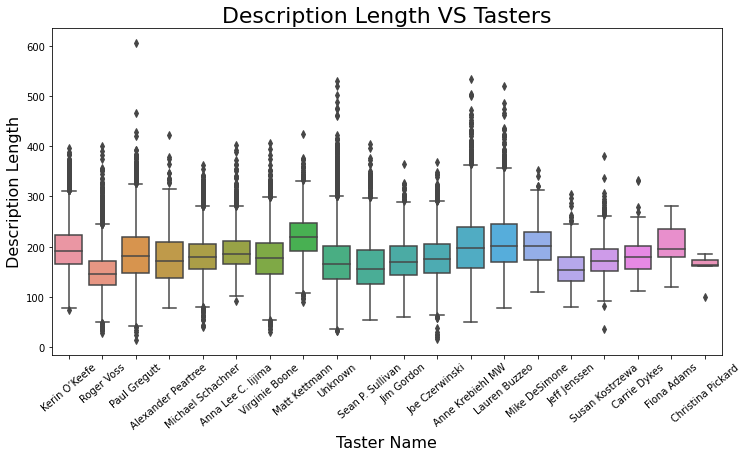

In [ ]:
df = df.assign(desc_length = df['description'].apply(len))

plt.figure(figsize=(12,6))
g = sns.boxplot(x='taster', y='desc_length', data=df)
g.set_title('Description Length VS Tasters', fontsize=22)
g.set_ylabel('Description Length', fontsize = 16)
g.set_xlabel('Taster Name', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(),rotation=40)
plt.show()

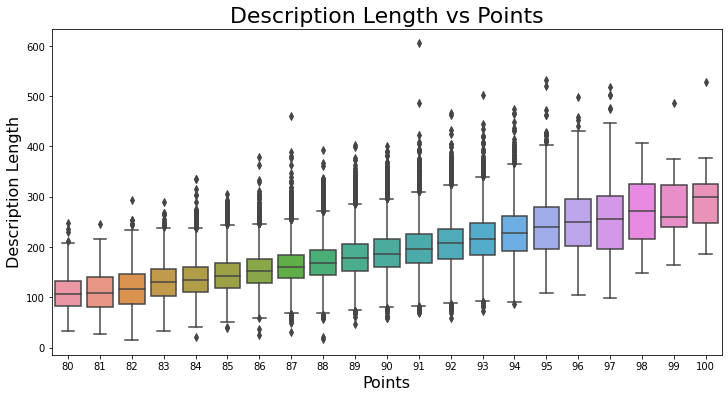

In [ ]:
# df = df.assign(desc_length = df['description'].apply(len))

plt.figure(figsize=(12,6))
g = sns.boxplot(x='points', y='desc_length', data=df)
g.set_title('Description Length VS Points', fontsize=22)
g.set_ylabel('Description Length', fontsize = 16) 
g.set_xlabel('Points', fontsize = 16) 
plt.show()

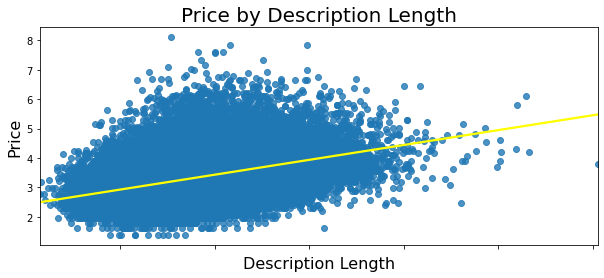

In [ ]:
plt.figure(figsize=(10,4))

g = sns.regplot(x='desc_length', y='price_log', line_kws={'color':'yellow'},data=, fit_reg=True)
g.set_title('Price by Description Length', fontsize=20)
g.set_ylabel('Price', fontsize = 16) 
g.set_xlabel('Description Length', fontsize = 16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)

plt.show()

In [ ]:
#filter the top 15 varieties of wines that have most descriptions
df_variety = df
filter = df_variety['variety'].isin(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend',
                           'Bordeaux-style Red Blend', 'Riesling', 'Sauvignon Blanc',
                           'Syrah', 'Rosé', 'Merlot', 'Nebbiolo', 'Zinfandel', 'Sangiovese',
                           'Malbec', 'Portuguese Red'])
df_top15_variety = df_variety[filter]

#create stop words list and tokenize the words
stop_words = text.ENGLISH_STOP_WORDS
desc = df_top15_variety['description'].values
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

#get vectorized verison of the reviews
vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X = vectorizer.fit_transform(desc)
words = vectorizer.get_feature_names()

#fit the k-means model
kmeans = KMeans(n_clusters = 15, n_init = 5, n_jobs = -1)
kmeans.fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=15, n_init=5, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : sweet, flavor, wine, soft, cherri, like, tast, finish, fruit, raspberri
1 : blackberri, currant, flavor, dri, tannin, cabernet, rich, cherri, oak, wine
2 : nose, palat, bottl, cherri, black, red, cranberri, flavor, fruit, touch
3 : appl, lemon, citrus, flavor, finish, palat, fresh, green, lime, wine
4 : palat, alongsid, tannin, aroma, cherri, black, offer, berri, red, spice
5 : berri, finish, herbal, aroma, flavor, plum, feel, palat, note, oak
6 : chardonnay, pineappl, butter, flavor, toast, oak, vanilla, acid, pear, tropic
7 : riesl, peach, finish, miner, honey, dri, acid, lime, tangerin, palat
8 : pinot, noir, cherri, raspberri, silki, flavor, cola, acid, dri, drink
9 : black, cherri, wine, pepper, fruit, tannin, flavor, finish, plum, aroma
10 : wine, fruit, flavor, cherri, finish, tannin, oak, red, acid, light
11 : aroma, herb, flavor, fruit, spice, barrel, lead, follow, note, bring
12 : cabernet, sauvignon, merlot, blend, franc, petit, verdot, malbec, syrah, cherri
13 : wine, f

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


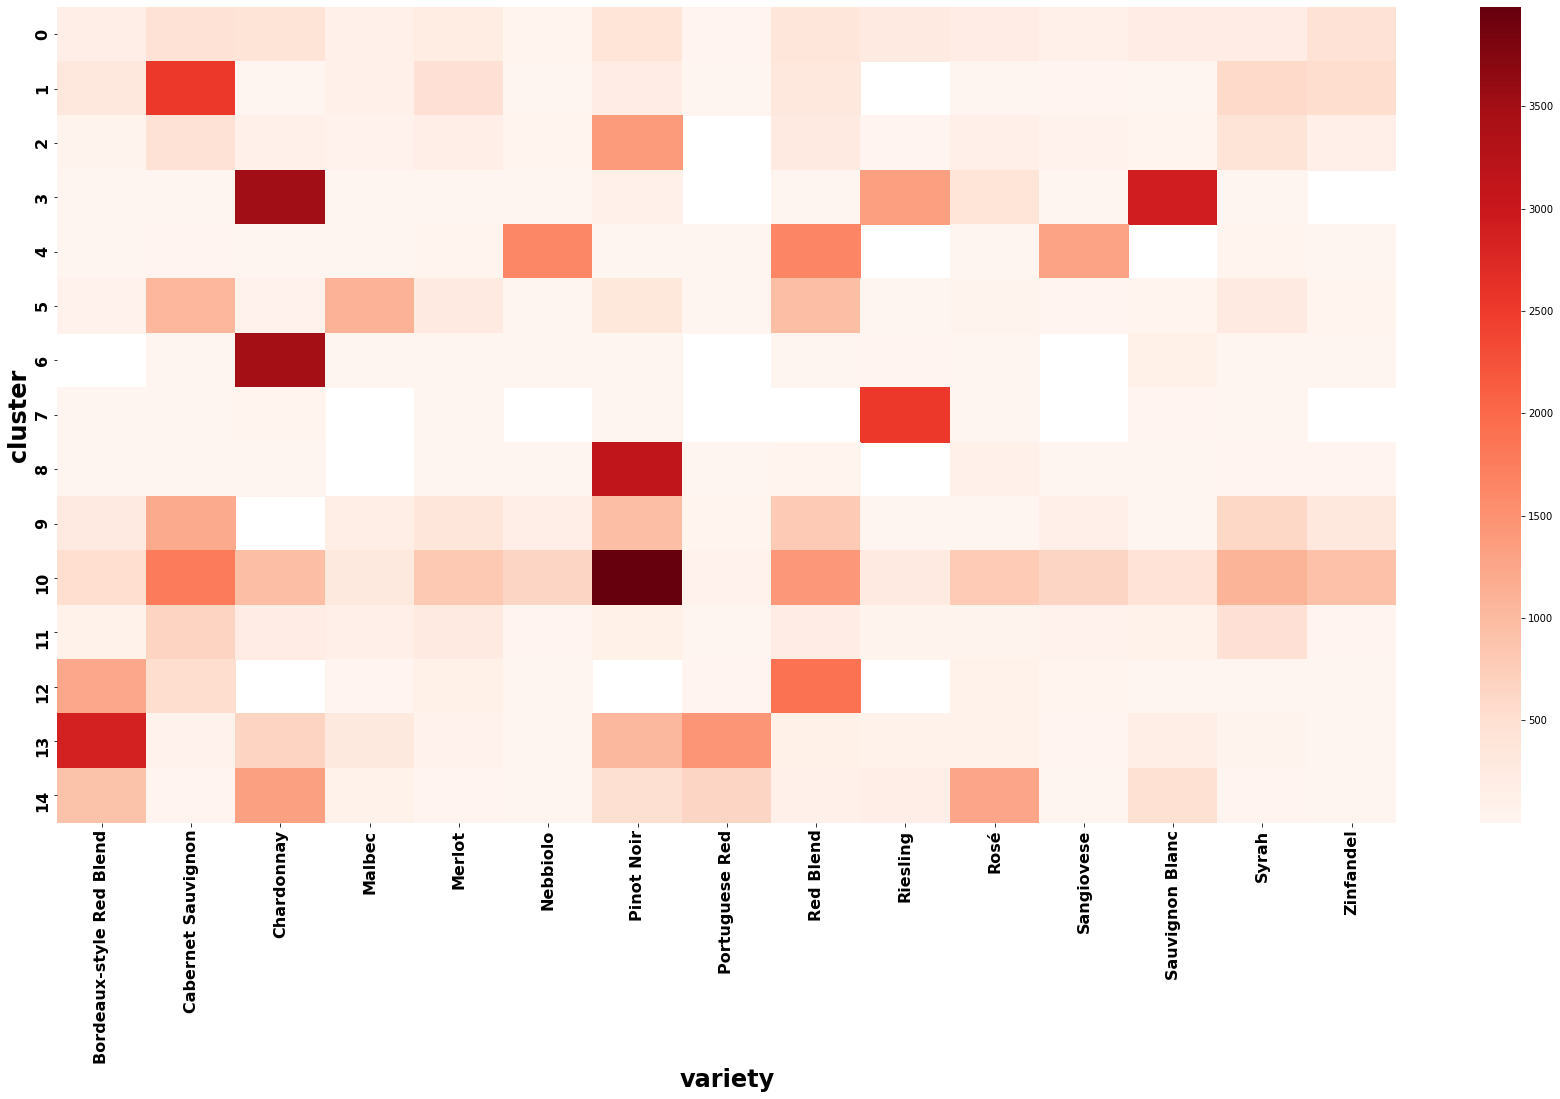

In [ ]:
#Plot a heatmap of the clusters and varieties
df_top15_variety['cluster'] = kmeans.labels_
clusters = df_top15_variety.groupby(['cluster', 'variety']).size()
fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(clusters.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

# **Data Modeling and Prediction**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation as LDA

In [ ]:
# Since our dataset is too large to run on limited RAM of colab, we sliced the dataset and picked 20000 
# data points from original dataset randomly with 10000 target = 1 and 10000 target = 0
df_recommend = df[df.target == 1].reset_index()[['description','target']]
df_nonrecommend = df[df.target == 0].reset_index()[['description','target']]

df_recommend = df_recommend.iloc[np.random.choice(len(df_recommend),10000,replace = False)]
df_nonrecommend = df_nonrecommend.iloc[np.random.choice(len(df_nonrecommend),10000,replace = False)]

df_toy = pd.concat([df_recommend,df_nonrecommend],ignore_index = True)

### **Word Embedding**

In [ ]:
############################## Bag of Words #########################
def BOW(corpus):
  vectorizer = CountVectorizer(max_features=10000) # corpus is a list of str
  X = vectorizer.fit_transform(corpus).toarray()
  return vectorizer, X

############################### Glove ################################
def create_corpus_new(df):
    corpus=[]
    for tweet in df['description']:
        words=[word.lower() for word in word_tokenize(tweet)]
        corpus.append(words)
    return corpus

def glove(df):
  corpus=create_corpus_new(df)
  embedding_dict={} 
  with open('/content/drive/MyDrive/CIS545_2020/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word = values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
  f.close()

  MAX_LEN=100
  tokenizer_obj=Tokenizer()
  tokenizer_obj.fit_on_texts(corpus)
  sequences=tokenizer_obj.texts_to_sequences(corpus)

  tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post') 

  return  tweet_pad


############################ TF-IDF ###########################
def tfidf(X):
  tv = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None)
  X = tv.fit_transform(X)
  return tv,X

### **Machine Learning Model**

In [ ]:
##################### Logistic Regression #####################
def LR(X, y):
  clf = LogisticRegression(random_state=0,max_iter=1000).fit(X, y)
  return clf

#################### SVM ######################################
def SVM(X, y, kernel):
  clf = svm.SVC(kernel=kernel)
  clf.fit(X, y)
  return clf

#################### KNN ######################################
def knn(X,y,n):
  clf = KNeighborsClassifier(n_neighbors=n)
  clf.fit(X,y)
  return clf

#################### Random Forest ############################
def rf(X,y,n):
  clf = RandomForestClassifier(n_estimators=n)
  clf.fit(X,y)
  return clf

### **Model Evaluation**

In [ ]:
##################### ROC curve ###############################
def plot_roc(model, X_test, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.decision_function(X_test))
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return fpr, tpr, thresholds

### **Bag of Words + Logistic Regression**

In [ ]:
#### Bag of Words Plus Logistic Regression
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
vectorizer, X_train = BOW(X_train)
X_test = vectorizer.transform(X_test)

clf = LR(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.81125

In [ ]:
f1_score(y_test,y_pred)

0.8108243547982962

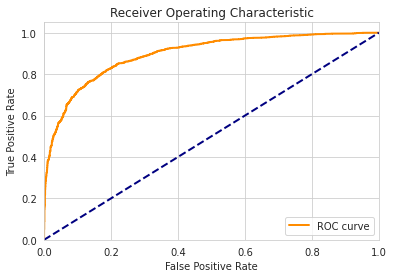

AUC: 0.8963473953524305


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **Bag of Words + PCA + KNN**

In [ ]:
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
vectorizer, X_train = BOW(X_train)
X_test = vectorizer.transform(X_test)

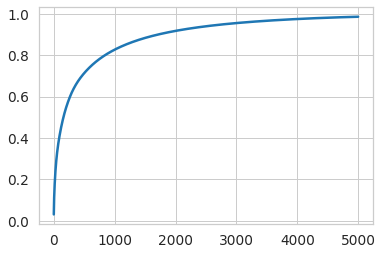

In [ ]:
#### select a proper value of component
pca = PCA(n_components = 5000)
pca.fit(X_train)
pc_vs_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(pc_vs_variance)
plt.show()

In [ ]:
# Based on the plot above, we go with n_components = 4000
pca = PCA(n_components = 4000)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test.toarray())

In [ ]:
clf = knn(X_train,y_train,10)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.51

In [ ]:
f1_score(y_test,y_pred)

0.060402684563758385

### **Bag of Words + PCA + Random Forest**

In [ ]:
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
vectorizer, X_train = BOW(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
pca = PCA(n_components = 4000)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test.toarray())

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.68775

In [ ]:
f1_score(y_test,y_pred)

0.6999759788613981

### **Bag of Words + PCA + SVM**

In [ ]:
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
vectorizer, X_train = BOW(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
# Based on the plot above, we go with n_components = 4000
pca = PCA(n_components = 4000)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test.toarray())

In [ ]:
clf = SVM(X_train, y_train, kernel = 'linear')
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8

In [ ]:
f1_score(y_test,y_pred)

0.8008959681433548

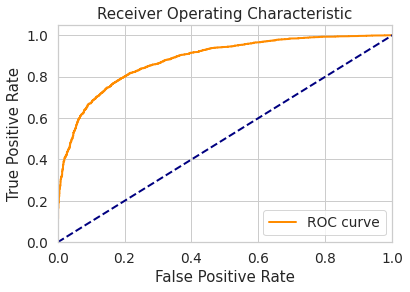

AUC: 0.8820086012762651


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **TF-IDF + Logistic Regression**

In [ ]:
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
tv, X_train = tfidf(X_train)
X_test = tv.transform(X_test)

clf = LR(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.7735

In [ ]:
f1_score(y_test,y_pred)

0.7739520958083833

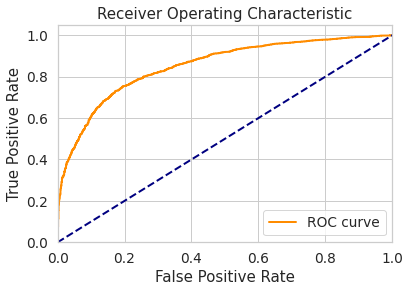

AUC: 0.851239574371587


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **TF-IDF + KNN**

In [ ]:
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
tv, X_train = tfidf(X_train)
X_test = tv.transform(X_test)

In [ ]:
clf = knn(X_train,y_train,5)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.50675

In [ ]:
f1_score(y_test,y_pred)

0.0491566265060241

### **TF-IDF + Random Forest**

In [ ]:
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
tv, X_train = tfidf(X_train)
X_test = tv.transform(X_test)

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.79375

In [ ]:
f1_score(y_test,y_pred)

0.7840879350955248

### **TF-IDF + SVM**

In [ ]:
X = df_toy['description']
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)
tv, X_train = tfidf(X_train)
X_test = tv.transform(X_test)

In [ ]:
clf = SVM(X_train, y_train, kernel = 'rbf')
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.822

In [ ]:
f1_score(y_test,y_pred)

0.821105527638191

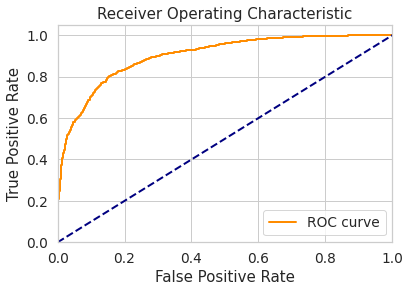

AUC: 0.9005352733084161


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **Glove + Logistic Regression**

In [ ]:
X = glove(df_toy)
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [ ]:
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.6255

In [ ]:
f1_score(y_test,y_pred)

0.5262492093611638

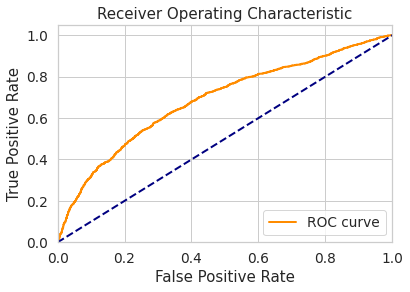

AUC: 0.6861826779866883


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **Glove + KNN**

In [ ]:
X = glove(df_toy)
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [ ]:
clf = knn(X_train,y_train,10)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.637

In [ ]:
f1_score(y_test,y_pred)

0.5644871025794841

### **Glove + Random Forest**

In [ ]:
X = glove(df_toy)
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.751

In [ ]:
f1_score(y_test,y_pred)

0.7468225724453482

### **Glove + SVM**

In [ ]:
X = glove(df_toy)
y = df_toy['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [ ]:
clf = SVM(X_train, y_train, kernel = 'rbf')
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.69525

In [ ]:
f1_score(y_test,y_pred)

0.6655692729766804

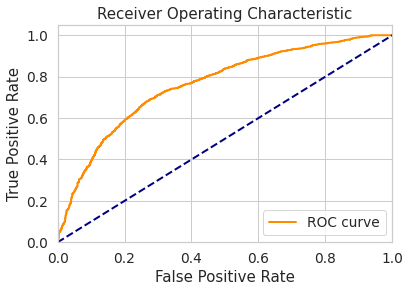

AUC: 0.7624450606667251


In [ ]:
fpr, tpr, thresholds = plot_roc(clf,X_test,y_test)
print('AUC:',auc(fpr,tpr))

### **Bag of Words + Nerual Network**

In [ ]:
#Extract description and target data from the originial cleaned dataframe
target_df = df[['description', 'target']]
text = target_df['description'].values
y = target_df['target'].values

#Split the data to training and testing datasets
text_train, text_test, y_train, y_test = train_test_split(text, y, test_size=0.25, random_state=1000)

#Fit the vecotizer using the training data
vectorizer = CountVectorizer()
vectorizer.fit(text_train)

#Vecotrize training and testing datasets
X_train = vectorizer.transform(text_train)
X_test  = vectorizer.transform(text_test)
X_train

<89946x37351 sparse matrix of type '<class 'numpy.int64'>'
	with 2207351 stored elements in Compressed Sparse Row format>

In [ ]:
#Define the input dimension to number of features
input_dim = X_train.shape[1]

#Build the Keras neural network model
model = Sequential()
model.add(layers.Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.80))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.80))
model.add(layers.Dense(1, activation='sigmoid'))

#Complie the model
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4781056   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,785,217
Trainable params: 4,785,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Fitting the model to our training data, record the history of each epoch in history
history = model.fit(X_train, y_train,
                     epochs=10,
                     verbose=False,
                     validation_data=(X_test, y_test),
                     batch_size=50)

#Print training accuracy and testing accuracy
dloss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9220
Testing Accuracy:  0.8635


In [ ]:
#Compute the f1 score of the model
y_prediction = model.predict(X_test)
y_pred = [1 if i >= 0.5 else 0 for i in y_prediction] 
f1_score(y_test, y_pred)

0.9084481832826203

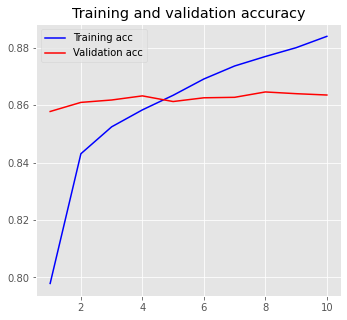

In [ ]:
#Plot the training and validation accuracy through out the epoches
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

plot_history(history)